In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
! pip install transformers datasets evaluate jiwer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-f

In [3]:
from datasets import load_dataset
ds = load_dataset('reach-vb/pokemon-blip-captions')
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

(…)-00000-of-00001-566cc9b19d7203f8.parquet:   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

In [4]:
ds = ds['train'].train_test_split(test_size=0.8)
ds = ds['train']
ds = ds.train_test_split(test_size=0.2)
train_ds = ds['train']
test_ds = ds['test']

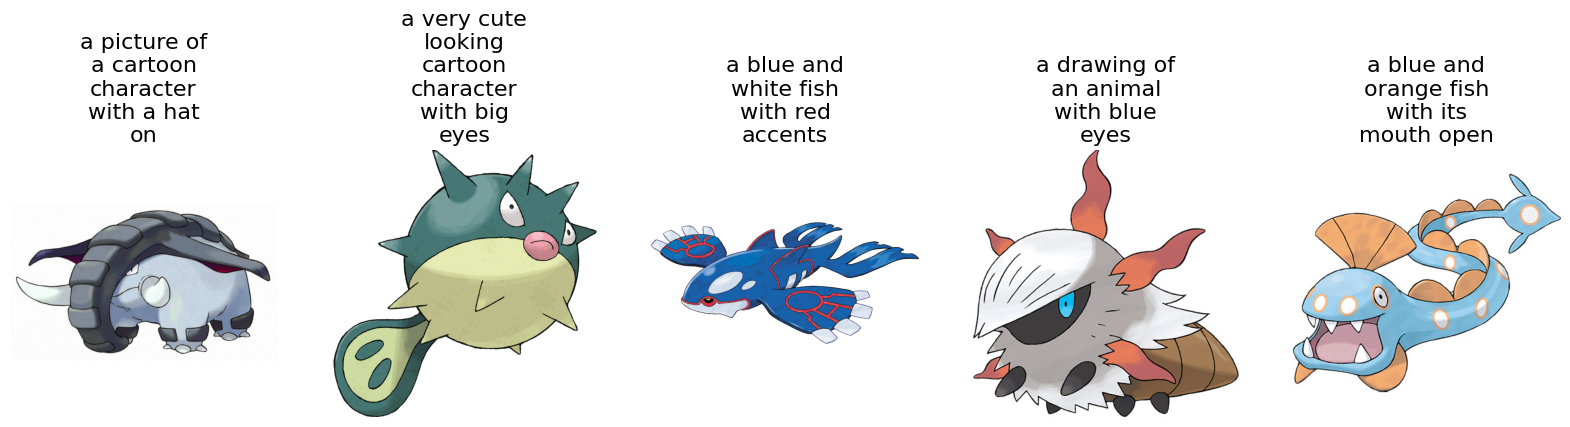

In [5]:
from textwrap import wrap
from matplotlib import pyplot as plt
import numpy as np

def plot_images(images, captions):
  plt.figure(figsize=(20,20))
  for i in range(len(images)):
    ax = plt.subplot(1, len(images), i+1)
    caption = captions[i]
    caption = "\n".join(wrap(caption, 12))
    plt.title(caption, fontsize=16)
    plt.axis("off")
    plt.imshow(images[i])


sample_images_to_visualize = [np.array(train_ds[i]['image']) for i in range(5)]
sample_captions = [train_ds[i]['text'] for i in range(5)]

plot_images(sample_images_to_visualize, sample_captions)

In [6]:
from transformers import AutoProcessor

checkpoint = 'microsoft/git-base'
processor = AutoProcessor.from_pretrained(checkpoint)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
def transform(example_batch):
  images = [x for x in example_batch['image']]
  captions = [x for x in example_batch['text']]
  inputs = processor(images=images, text=captions, padding='max_length', return_tensors='pt')
  inputs.update({'labels': inputs['input_ids']})
  return inputs

train_ds.set_transform(transform)
test_ds.set_transform(transform)

In [8]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [9]:
from evaluate import load
import torch

# word error rate
wer = load('wer')

def compute_metrics(eval_pred):

  logits, label = eval_pred
  predicted = logits.argmax(-1)
  decoded_labels = processor.batch_decode(label, skip_special_tokens=True)
  decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
  result = wer.compute(predictions=decoded_predictions, references=decoded_labels)

  return result

In [12]:
from transformers import TrainingArguments, Trainer
from transformers import default_data_collator
import os

output_dir = os.path.join("../working/chache", "captioning_outputs")

training_args = TrainingArguments(
  output_dir=output_dir,
  learning_rate=1e-5,
  num_train_epochs=2,
  fp16=True,
  per_device_train_batch_size=2,
  per_device_eval_batch_size=2,
  gradient_accumulation_steps=16,
  remove_unused_columns=False,
  label_names=['labels'],
  report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [13]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=8, training_loss=9.757770538330078, metrics={'train_runtime': 42.7236, 'train_samples_per_second': 6.179, 'train_steps_per_second': 0.187, 'total_flos': 119726755282944.0, 'train_loss': 9.757770538330078, 'epoch': 1.9393939393939394})

In [20]:
import os
os.getcwd()

'/content'

In [21]:
os.listdir()

['.config', 'drive', 'sample_data']

In [16]:
from PIL import Image
import requests

def display_image(url):
  image = Image.open(requests.get(url, stream=True).raw)
  display(image)
  return image

def generate_captions(image):
  device = 'cuda' if torch.cuda.is_available else 'cpu'
  inputs = processor(images=image, return_tensors='pt').to(device)
  pixel_values = inputs.pixel_values
  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
  return generated_text

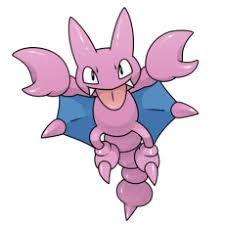

['a picture of a cute pink toy in the shape of a heart']


In [17]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT2WJe1rqww9JKg9YPeMZVAQRQAYtjs0EMMzDaS21ljTTT_nPmA"
image = display_image(url)
captions = generate_captions(image)
print(captions)

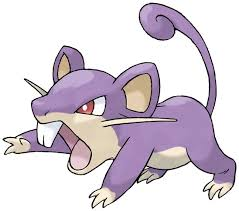

['a cute illustration of a purple and white cat']


In [18]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQf2NbpcW4a1__ejOQ12bdffBy3nGgPiGps3Q&usqp=CAU"
image=display_image(url)
answer = generate_captions(image)
print(answer)